In [1]:
#导入相关依赖库（不一定全部用到）
import  os
import csv
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import mindspore as ms
import mindspore.dataset as ds
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

from mindspore import nn, Tensor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy, MAE, MSE
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU')

In [2]:
#加载并观察数据集，为数据处理做准备
with open('./auto-mpg.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))

In [3]:
print(len(data))

398


In [4]:
data[:10]

[['18.0   8   307.0      130.0      3504.      12.0   70  1\t"chevrolet chevelle malibu"'],
 ['15.0   8   350.0      165.0      3693.      11.5   70  1\t"buick skylark 320"'],
 ['18.0   8   318.0      150.0      3436.      11.0   70  1\t"plymouth satellite"'],
 ['16.0   8   304.0      150.0      3433.      12.0   70  1\t"amc rebel sst"'],
 ['17.0   8   302.0      140.0      3449.      10.5   70  1\t"ford torino"'],
 ['15.0   8   429.0      198.0      4341.      10.0   70  1\t"ford galaxie 500"'],
 ['14.0   8   454.0      220.0      4354.       9.0   70  1\t"chevrolet impala"'],
 ['14.0   8   440.0      215.0      4312.       8.5   70  1\t"plymouth fury iii"'],
 ['14.0   8   455.0      225.0      4425.      10.0   70  1\t"pontiac catalina"'],
 ['15.0   8   390.0      190.0      3850.       8.5   70  1\t"amc ambassador dpl"']]

In [5]:
#MPG:Miles Per Gallon,每加仑燃油可以跑多少英里
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

#利用pandas读取数据并对其进行初步处理，如：遇到？换成nan，忽略\t之后的内容等
raw_data = pd.read_csv('auto-mpg.data', names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)
data = raw_data.copy()


In [6]:
print(data.shape)
data[:5]

(398, 8)


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [7]:
#对于数据集中的空值，我们要进行处理。
dataset = data.dropna()  #空值数据较少，直接进行删除

#查看训练数据集的结构，代码需自己补充
origin = data.pop('Origin')
data_labels = data.pop('MPG')
train_stats = data.describe()
train_stats = train_stats.transpose()
print(train_stats)


              count         mean         std     min       25%     50%  \
Cylinders     398.0     5.454774    1.701004     3.0     4.000     4.0   
Displacement  398.0   193.425879  104.269838    68.0   104.250   148.5   
Horsepower    392.0   104.469388   38.491160    46.0    75.000    93.5   
Weight        398.0  2970.424623  846.841774  1613.0  2223.750  2803.5   
Acceleration  398.0    15.568090    2.757689     8.0    13.825    15.5   
Model Year    398.0    76.010050    3.697627    70.0    73.000    76.0   

                   75%     max  
Cylinders        8.000     8.0  
Displacement   262.000   455.0  
Horsepower     126.000   230.0  
Weight        3608.000  5140.0  
Acceleration    17.175    24.8  
Model Year      79.000    82.0  


In [8]:
#对特征进行归一化
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(data)
print(data)
print(normed_data)

     Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year
0            8         307.0       130.0  3504.0          12.0          70
1            8         350.0       165.0  3693.0          11.5          70
2            8         318.0       150.0  3436.0          11.0          70
3            8         304.0       150.0  3433.0          12.0          70
4            8         302.0       140.0  3449.0          10.5          70
..         ...           ...         ...     ...           ...         ...
393          4         140.0        86.0  2790.0          15.6          82
394          4          97.0        52.0  2130.0          24.6          82
395          4         135.0        84.0  2295.0          11.6          82
396          4         120.0        79.0  2625.0          18.6          82
397          4         119.0        82.0  2720.0          19.4          82

[398 rows x 6 columns]
     Cylinders  Displacement  Horsepower    Weight  Acceleration  Model Year

In [9]:
# 将MPG放回归一化后的数据中
normed_data['MPG'] = data_labels
normed_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,MPG
0,1.496308,1.089233,0.663285,0.630077,-1.293870,-1.625381,18.0
1,1.496308,1.501624,1.572585,0.853259,-1.475181,-1.625381,15.0
2,1.496308,1.194728,1.182885,0.549778,-1.656492,-1.625381,18.0
3,1.496308,1.060461,1.182885,0.546236,-1.293870,-1.625381,16.0
4,1.496308,1.041280,0.923085,0.565130,-1.837804,-1.625381,17.0
...,...,...,...,...,...,...,...
393,-0.855244,-0.512381,-0.479835,-0.213056,0.011571,1.619944,27.0
394,-0.855244,-0.924773,-1.363154,-0.992422,3.275173,1.619944,44.0
395,-0.855244,-0.560333,-0.531795,-0.797581,-1.438919,1.619944,32.0
396,-0.855244,-0.704191,-0.661694,-0.407897,1.099439,1.619944,28.0


In [10]:
#将数据集按照4：1划分成训练集和测试集
train_dataset = normed_data.sample(frac=0.8, random_state=0)
test_dataset = normed_data.drop(train_dataset.index)

#模型训练需要区分特征值与目标值，也就是我们常说的X值与Y值，此处MPG为Y值，其余的特征为X值。
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
X_train, Y_train = np.array(train_dataset), np.array(train_labels)
X_test, Y_test = np.array(test_dataset), np.array(test_labels)

#查看数据集尺寸
print('Train X：',X_train.shape)
print('Train Y：',Y_train.shape)
print('Test X：',X_test.shape)
print('Test Y：',Y_test.shape)

Train X： (318, 6)
Train Y： (318,)
Test X： (80, 6)
Test Y： (80,)


In [11]:
#离散特征处理
#特征Origin代表着车辆的归属区域信息，此处总共分为三种，欧洲，美国，日本，故对此特征进行one-hot编码。
normed_data['USA'] = (origin == 1)*1.0
normed_data['Europe'] = (origin == 2)*1.0
normed_data['Japan'] = (origin == 3)*1.0
normed_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,MPG,USA,Europe,Japan
0,1.496308,1.089233,0.663285,0.630077,-1.293870,-1.625381,18.0,1.0,0.0,0.0
1,1.496308,1.501624,1.572585,0.853259,-1.475181,-1.625381,15.0,1.0,0.0,0.0
2,1.496308,1.194728,1.182885,0.549778,-1.656492,-1.625381,18.0,1.0,0.0,0.0
3,1.496308,1.060461,1.182885,0.546236,-1.293870,-1.625381,16.0,1.0,0.0,0.0
4,1.496308,1.041280,0.923085,0.565130,-1.837804,-1.625381,17.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,-0.855244,-0.512381,-0.479835,-0.213056,0.011571,1.619944,27.0,1.0,0.0,0.0
394,-0.855244,-0.924773,-1.363154,-0.992422,3.275173,1.619944,44.0,0.0,1.0,0.0
395,-0.855244,-0.560333,-0.531795,-0.797581,-1.438919,1.619944,32.0,1.0,0.0,0.0
396,-0.855244,-0.704191,-0.661694,-0.407897,1.099439,1.619944,28.0,1.0,0.0,0.0


In [12]:
#将数据集转换为Tensor格式
ds_xtrain = Tensor(X_train, ms.float32)
ds_ytrain = Tensor(Y_train, ms.int32)
ds_xtest = Tensor(X_test, ms.float32)
ds_ytest = Tensor(Y_test, ms.int32)
print(ds_xtrain.shape,ds_ytrain.shape)
print(ds_xtest.shape,ds_ytest.shape)

(318, 6) (318,)
(80, 6) (80,)


In [13]:
!pip install seaborn

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 292 kB 18.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ma-user/anaconda3/envs/MindSpore/bin/python3.7 -m pip install --upgrade pip' command.


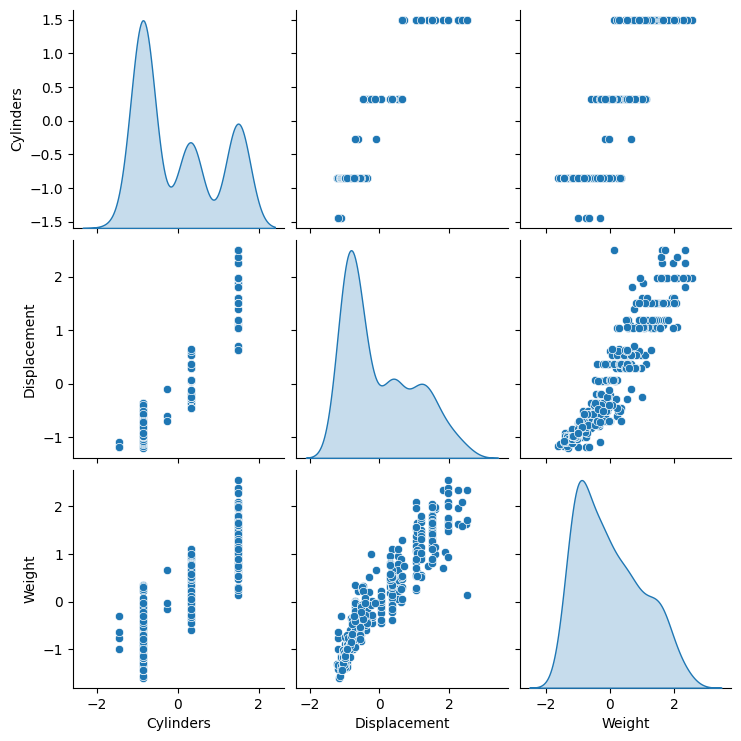

In [14]:
#可视化特征关系
#利用seaborn模块中的pairplot方法实现特征相关性的简单可视化操作。
#相关性是特征工程中考察特征间联系的重要手段。在传统机器学习领域，相关性往往决定了如何进行特征选择。
import seaborn
seaborn.pairplot(normed_data[["Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [15]:
# 定义网络
class Regression_car(nn.Cell):
    def __init__(self):
        super(Regression_car, self).__init__()
        self.fc1 = nn.Dense(6, 64, activation='relu')
        self.fc2 = nn.Dense(64, 64, activation='relu')
        self.fc3 = nn.Dense(64, 1, activation='relu')
        self.flatten = nn.Flatten()
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [16]:
#定义网络，损失函数，评估指标，优化器
network = Regression_car()
net_loss = nn.MSELoss()
net_opt = nn.RMSProp(network.trainable_params(), 0.001)
max_epoch = 1000
n=50

#使用单步训练的方式来使结果中打印出MAE、MSE
with_loss=nn.WithLossCell(network,net_loss) 
train_step = nn.TrainOneStepCell(with_loss, net_opt).set_train()
evalcell=nn.WithEvalCell(network,net_loss)
mae = nn.MAE()
mse = nn.MSE()
val_mae = nn.MAE()
val_mse = nn.MSE()

#创建一个空的Dataframe，存放训练过程数据
#column包括epoch、loss等数据
result =pd.DataFrame(columns=('_epoch','_loss','_mae','_mse','val_loss','val_mae','val_mse'))
print("Starting Training".center(92,"="))

for epoch in range(max_epoch):
    # 训练函数
    loss,val_loss = train_step(ds_xtrain,ds_ytrain),train_step(ds_xtest, ds_ytest)
    _, outputs, label = evalcell(ds_xtrain,ds_ytrain)
    _, val_outputs, val_label = evalcell(ds_xtest,ds_ytest)
    
    #每次循环都更新MAE、MSE等的值。
    mae.clear()
    mae.update(outputs, label)
    mse.clear()
    mse.update(outputs, label)
    val_mae.clear()
    val_mae.update(val_outputs, val_label)
    val_mse.clear()
    val_mse.update(val_outputs, val_label)
    Mae = mae.eval()
    Mse = mse.eval()
    Val_Mae = val_mae.eval()
    Val_Mse = val_mse.eval()
    nd_loss = loss.asnumpy()
    fl_loss = float(nd_loss)/24.0
    val_nd_loss = val_loss.asnumpy()
    val_fl_loss = float(val_nd_loss)/24.0

    #将计算结果逐行插入result,注意变量要用[]括起来,同时ignore_index=True，否则会报错，ValueError: If using all scalar values, you must pass an index
    result=result.append(pd.DataFrame({'_epoch':[epoch],'_loss':fl_loss,'_mae':Mae,'_mse':Mse,'val_loss':val_fl_loss,
                                       'val_mae':Val_Mae,'val_mse':Val_Mse}),ignore_index=True)

    # 每隔n个epoch展示
    if epoch%n==0:
        print('epoch:{:.0f}, loss:{:.2f}, mae:{:.2f}, mse:{:.2f}, val_loss:{:.2f}, val_mae:{:.2f}, val_mse:{:.2f}'
              .format(epoch,fl_loss,Mae,Mse,val_fl_loss,Val_Mae,Val_Mse))
        
# 训练结果
print('\n',result)

=====================================Starting Training======================================
epoch:0, loss:25.40, mae:23.42, mse:609.76, val_loss:24.40, val_mae:23.04, val_mse:585.44
epoch:50, loss:24.40, mae:22.88, mse:584.64, val_loss:23.38, val_mae:22.50, val_mse:560.72
epoch:100, loss:21.98, mae:21.56, mse:526.13, val_loss:21.00, val_mae:21.18, val_mse:503.20
epoch:150, loss:18.52, mae:19.53, mse:442.68, val_loss:17.59, val_mae:19.15, val_mse:421.27
epoch:200, loss:14.41, mae:16.80, mse:343.68, val_loss:13.55, val_mae:16.43, val_mse:324.31
epoch:250, loss:10.13, mae:13.41, mse:241.08, val_loss:9.38, val_mae:13.06, val_mse:224.26
epoch:300, loss:6.29, mae:9.66, mse:149.30, val_loss:5.68, val_mae:9.39, val_mse:135.49
epoch:350, loss:3.56, mae:7.12, mse:84.61, val_loss:3.11, val_mae:6.88, val_mse:74.21
epoch:400, loss:2.57, mae:6.51, mse:61.59, val_loss:2.27, val_mae:6.30, val_mse:54.42
epoch:450, loss:2.56, mae:6.52, mse:61.37, val_loss:2.27, val_mae:6.31, val_mse:54.42
epoch:500, lo

In [17]:
np.savetxt("result.txt",result,fmt="%s")

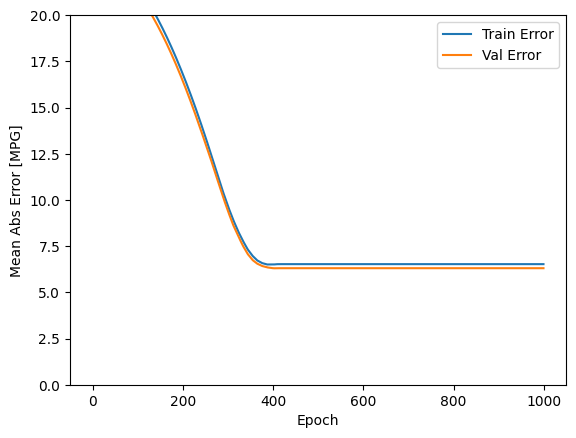

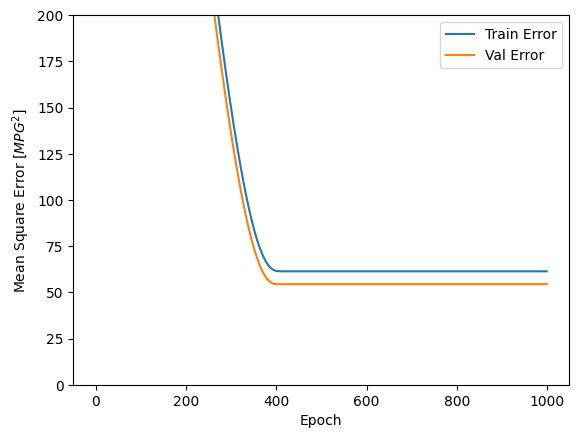

In [19]:
#绘制模型损失函数图（横轴为epoch）
def plot_history(result):
    # 此处为代码
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(result['_epoch'], result['_mae'], label='Train Error')
    plt.plot(result['_epoch'], result['val_mae'], label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(result['_epoch'], result['_mse'], label='Train Error')
    plt.plot(result['_epoch'], result['val_mse'], label='Val Error')
    plt.ylim([0,200])
    plt.legend()
    plt.show()

plot_history(result)